In [13]:
"""
Week 4 — Lesson 2, Video 4
Visualizing Impact of Transformations

Goal:
Show (visually) how transformations change distributions:
- Raw (cleaned)
- Log1p
- Power Transform (Yeo-Johnson)

We’ll visualize using:
1) Histogram overlays
2) Boxplot comparison
3) ECDF (cumulative distribution) comparison

Dataset: retail_sales_week4.csv
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

DATA_PATH = "D:/datasets/dpp/retail_sales_week4.csv"

FEATURES = ["annual_income", "monthly_spend", "avg_basket_value", "marketing_spend"]



In [14]:
# -----------------------------
# 1) Load + minimal cleaning
# -----------------------------
df = pd.read_csv(DATA_PATH)

df_clean = df.copy()

# Fix known "bad" values in this dataset
df_clean.loc[df_clean["annual_income"] <= 0, "annual_income"] = np.nan
df_clean.loc[df_clean["marketing_spend"] < 0, "marketing_spend"] = np.nan

# Median imputation for focus columns (robust under skew)
for c in FEATURES:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())



In [15]:
# -----------------------------
# 2) Create transformed versions
# -----------------------------
# Log1p (safe for positive values; we made sure they’re positive after cleaning)
df_log = df_clean.copy()
for c in FEATURES:
    df_log[c] = np.log1p(df_log[c])

# Power transform (Yeo-Johnson; works generally; we keep standardize=False so we only reshape)
pt = PowerTransformer(method="yeo-johnson", standardize=False)
df_power = df_clean.copy()
df_power[FEATURES] = pt.fit_transform(df_clean[FEATURES])



In [16]:
# -----------------------------
# 3) Quick numeric comparison (skew)
# -----------------------------
skew_tbl = pd.DataFrame({
    "skew_raw": df_clean[FEATURES].skew(),
    "skew_log1p": df_log[FEATURES].skew(),
    "skew_power_YJ": df_power[FEATURES].skew(),
}).round(3)

print("\nSkewness (closer to 0 is more symmetric):")
print(skew_tbl)



Skewness (closer to 0 is more symmetric):
                  skew_raw  skew_log1p  skew_power_YJ
annual_income        9.082       0.667         -0.055
monthly_spend       10.098       0.273         -0.016
avg_basket_value    14.950       0.235         -0.007
marketing_spend      7.570       0.174         -0.005



--- Visualizing: annual_income ---


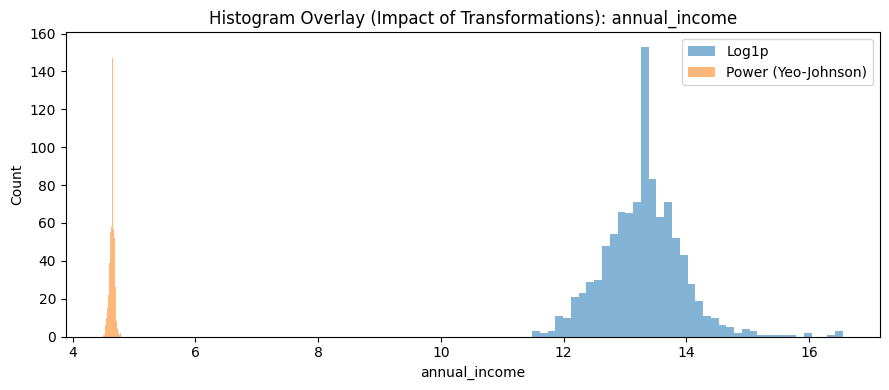

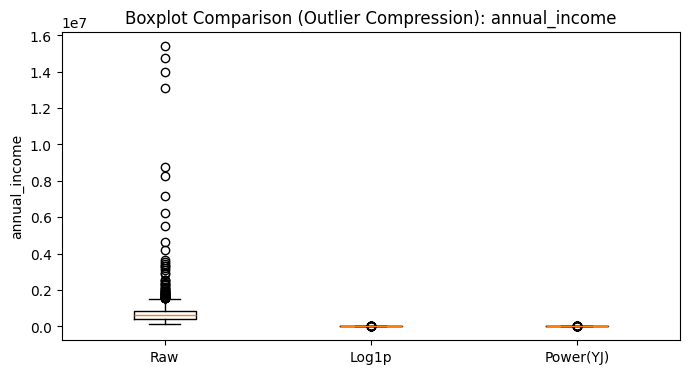

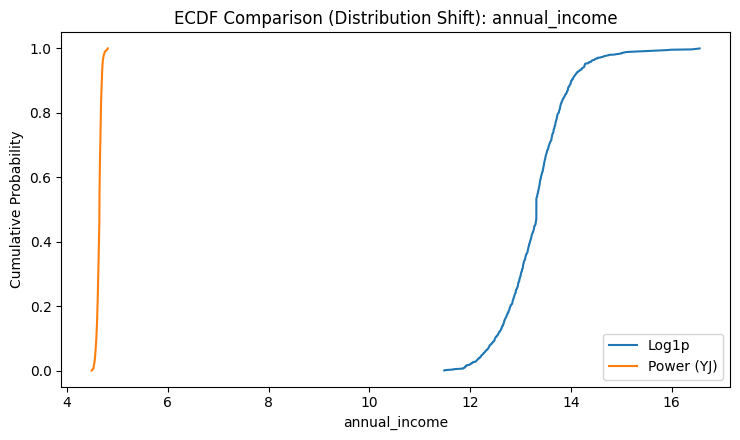


--- Visualizing: monthly_spend ---


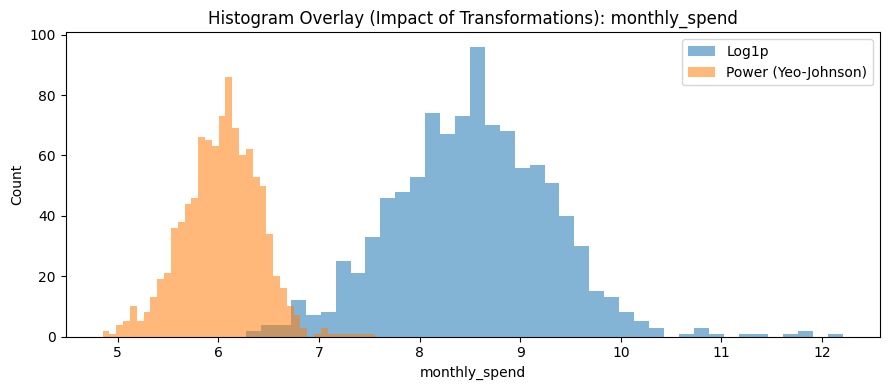

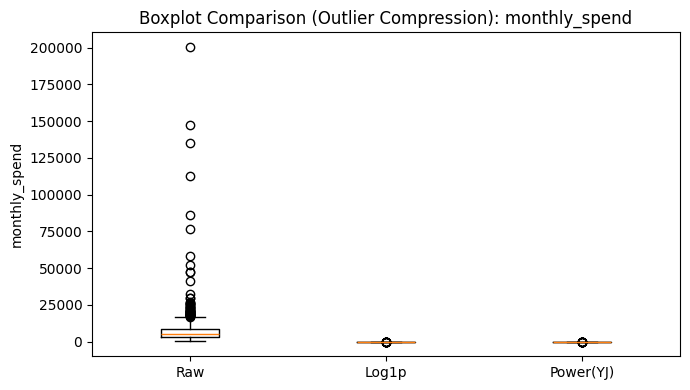

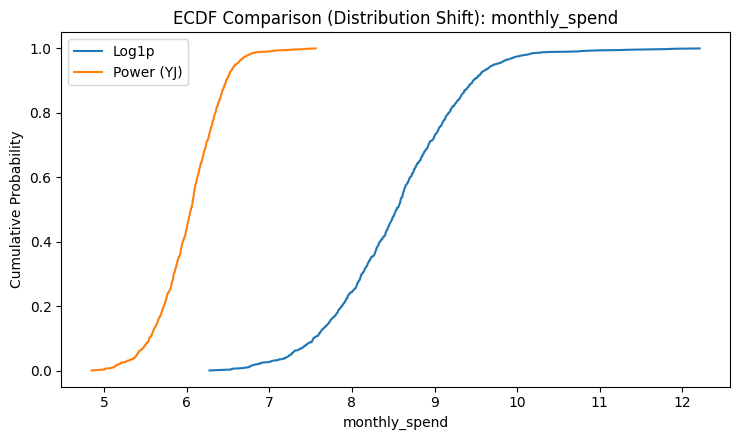


--- Visualizing: avg_basket_value ---


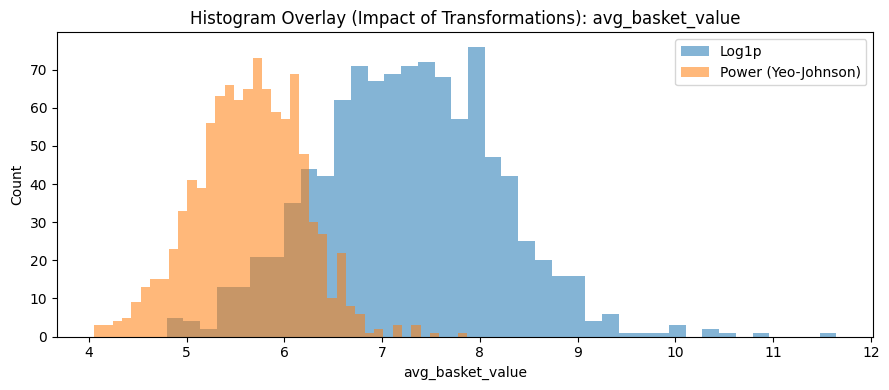

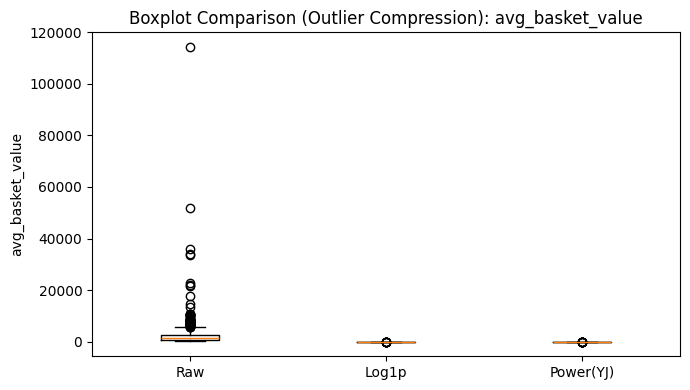

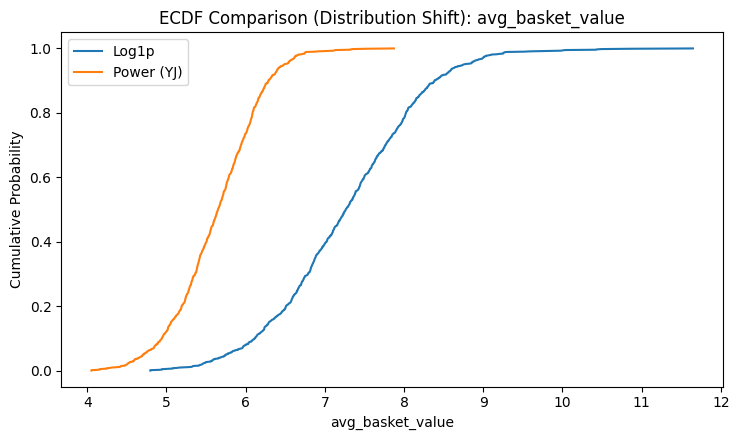


--- Visualizing: marketing_spend ---


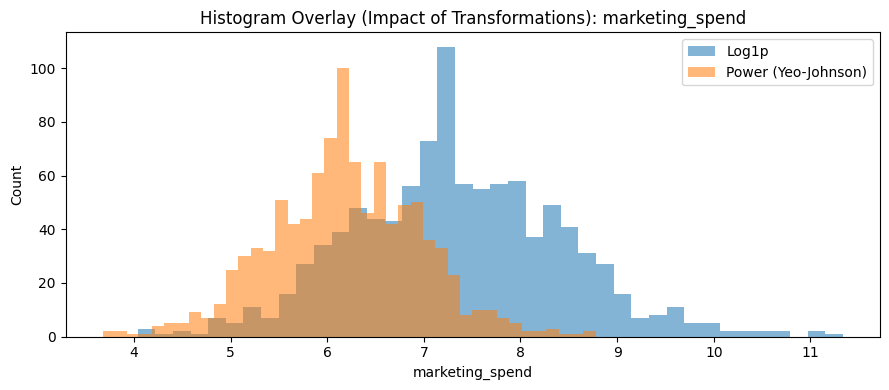

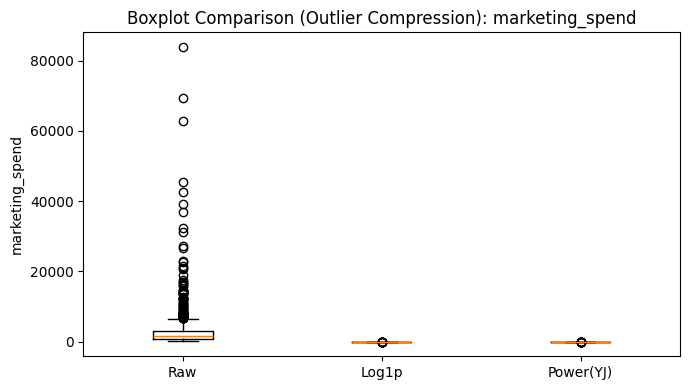

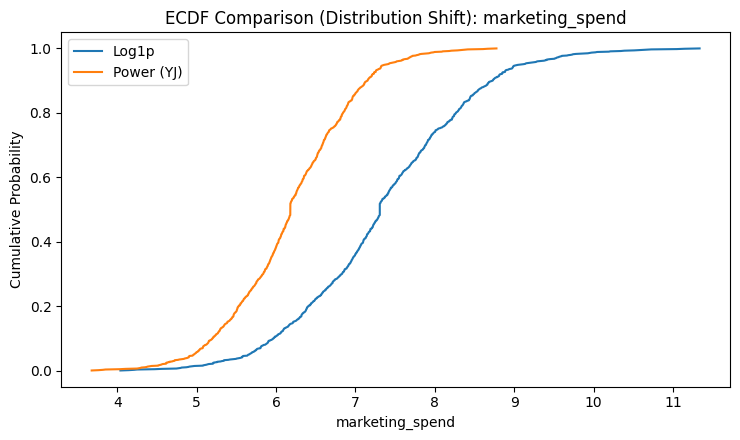


Done. You can now 'see' whether transformations improved symmetry and reduced tail dominance.


In [19]:
# -----------------------------
# 4) Visualization helpers
# -----------------------------
def plot_hist_overlay(col: str, bins: int = 40):
    """Overlay histograms: Raw vs Log1p vs Power(YJ)."""
    plt.figure(figsize=(9, 4))
    #plt.hist(df_clean[col], bins=bins, alpha=0.55, label="Raw (cleaned)")
    plt.hist(df_log[col], bins=bins, alpha=0.55, label="Log1p")
    plt.hist(df_power[col], bins=bins, alpha=0.55, label="Power (Yeo-Johnson)")
    plt.title(f"Histogram Overlay (Impact of Transformations): {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_box_compare(col: str):
    """Side-by-side comparison via boxplots."""
    plt.figure(figsize=(7, 4))
    plt.boxplot(
        [df_clean[col].values, df_log[col].values, df_power[col].values],
        tick_labels=["Raw", "Log1p", "Power(YJ)"],
        showfliers=True
    )
    plt.title(f"Boxplot Comparison (Outlier Compression): {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

def plot_ecdf(col: str):
    """
    ECDF comparison helps show distribution shifts without binning.
    
    """
    def ecdf(x):
        x = np.sort(x)
        y = np.arange(1, len(x) + 1) / len(x)
        return x, y

    x_raw, y_raw = ecdf(df_clean[col].values)
    x_log, y_log = ecdf(df_log[col].values)
    x_pow, y_pow = ecdf(df_power[col].values)

    plt.figure(figsize=(7.5, 4.5))
    #plt.plot(x_raw, y_raw, label="Raw (cleaned)")
    plt.plot(x_log, y_log, label="Log1p")
    plt.plot(x_pow, y_pow, label="Power (YJ)")
    plt.title(f"ECDF Comparison (Distribution Shift): {col}")
    plt.xlabel(col)
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5) Run visualizations per feature
# -----------------------------
for c in FEATURES:
    print(f"\n--- Visualizing: {c} ---")
    plot_hist_overlay(c)
    plot_box_compare(c)
    plot_ecdf(c)

print("\nDone. You can now 'see' whether transformations improved symmetry and reduced tail dominance.")
